## **Thin-films-Color-simulation is developed to simulate the color of multi-layer thin films.** 
<br>

The process involves calculating the reflectance spectrum in the visible wavelength range by considering complex refractive indices of materials, reflectance, transmittance, attenuation, and optical interference effects. 

<br>

The reflectance spectrum is then converted to the CIE XYZ color space using color matching functions, followed by a conversion to the sRGB color space through a transformation matrix and gamma compression.

<br>

This files contain modules and functions for simulating the color of structures such as SiO₂/Si, SnO₂/SiO₂/Si, and ZnO/SiO₂/Si. 

<br>

### **References**

If you find this code useful, please cite one of the following paper:

<br>

> Dongik Lee and Seunghun Lee, Color simulation of Multilayered Thin Films Using Python, *Advances Sciences*, XXX. Preprint on ArXiv: https://doi.org/10.48550/arXiv.2412.12828.

In [1]:
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
from scipy.interpolate import interp1d
import sys

print("Python version: ", sys.version)
print('Numpy version: ', np.__version__)
print('Matplotlib version: ', mat.__version__)
print('Pandas version: ', pd.__version__)
print('Scipy version: ', sci.__version__)

Python version:  3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Numpy version:  1.26.4
Matplotlib version:  3.9.2
Pandas version:  2.2.2
Scipy version:  1.13.0


# SnO₂

In [2]:
# Standard wavelength
wl = np.arange(380, 750.1, 1)

def load_refractive_index(filename):
     data = pd.read_csv(filename)
     return data.iloc[:, 0].values, data.iloc[:, 1].values

def load_complex_index(filename):
     data = pd.read_csv(filename)
     return data.iloc[:, 0].values, data.iloc[:, 1].values, data.iloc[:, 2].values

# Air n, k
N_air = complex(1.0003, -0)
# imagenary unit
j = complex(0, 1)

# SnO2
wl_sno2_n, n_sno2 = load_refractive_index('SnO2 n.csv')
wl_sno2_k, k_sno2 = load_refractive_index('SnO2 k.csv')
n_sno2_interp = interp1d(wl_sno2_n, n_sno2, kind = 'cubic')(wl)
k_sno2_interp = interp1d(wl_sno2_k, k_sno2, kind = 'cubic')(wl)
N_sno2 = n_sno2_interp - 1j * k_sno2_interp
 
# SiO2
wl_sio2_n, n_sio2 = load_refractive_index('SiO2 n.csv')
n_sio2_interp = interp1d(wl_sio2_n, n_sio2, kind = 'cubic')(wl)
N_sio2 = n_sio2_interp - 1j * 0  # No absorption
 
# Si
wl_si, n_si, k_si = load_complex_index('Si n k.csv')
n_si_interp = interp1d(wl_si, n_si, kind = 'cubic')(wl)
k_si_interp = interp1d(wl_si, k_si, kind = 'cubic')(wl)
N_si = n_si_interp - 1j * k_si_interp

# http://www.mtheiss.com/docs/code/?bk_d65_spectrum.htm
D65_spec = pd.read_csv("D65_step_1.csv")
D65 = D65_spec.iloc[0:371, 1].values
# http://cvrl.ucl.ac.uk/
# CMFs -> CIE 1931 2-deg, XYZ CMFs
cie_data = pd.read_csv('CIE_cc_1931_2deg_cvrl.csv')
cie_wl = cie_data.iloc[:, 0]
CMFs_X_b = cie_data.iloc[:, 1]; CMFs_Y_b = cie_data.iloc[:, 2]; CMFs_Z_b = cie_data.iloc[:, 3]

In [3]:
CMFs_X_i = interp1d(cie_wl, CMFs_X_b, kind = 'cubic')(wl)
CMFs_Y_i = interp1d(cie_wl, CMFs_Y_b, kind = 'cubic')(wl)
CMFs_Z_i = interp1d(cie_wl, CMFs_Z_b, kind = 'cubic')(wl)

In [4]:
# Eq. (4)
def reflection_p(N_j, N_k, ang_j, ang_k):
    r = (N_k * np.cos(ang_j) - N_j * np.cos(ang_k)) / (N_k * np.cos(ang_j) + N_j * np.cos(ang_k))
    return r
# Eq. (8)
def reflection_s(N_j, N_k, ang_j, ang_k):
    r = (N_j * np.cos(ang_j) - N_k * np.cos(ang_k)) / (N_j * np.cos(ang_j) + N_k * np.cos(ang_k))
    return r

def reflectance(wl, N_0, N_1, N_2, N_3, d_1, d_2, angle):
    # Snell's Law
    ang_0 = angle * np.pi / 180
    ang_1 = np.arcsin(N_0/N_1 * np.sin(ang_0))
    ang_2 = np.arcsin(N_0/N_2 * np.sin(ang_0))
    ang_3 = np.arcsin(N_0/N_3 * np.sin(ang_0))
    # Eq. (20)
    alpha_1 = 4 * np.pi * d_1 / wl * N_1 * np.cos(ang_1)
    alpha_2 = 4 * np.pi * d_2 / wl * N_2 * np.cos(ang_2)
    # Reflection coefficient of p-polarized wave at each interface
    r_01_p = reflection_p(N_0, N_1, ang_0, ang_1)
    r_12_p = reflection_p(N_1, N_2, ang_1, ang_2)
    r_23_p = reflection_p(N_2, N_3, ang_2, ang_3)
    # Eq. (27)
    r_0123_p = (r_01_p + r_12_p * np.exp(-j*alpha_1) 
                + (r_01_p*r_12_p + np.exp(-j*alpha_1))
                * r_23_p * np.exp(-j*alpha_2)) / (1 + r_01_p*r_12_p*np.exp(-j*alpha_1)
                                                   + (r_12_p + r_01_p*np.exp(-j*alpha_1))
                                                   * r_23_p*np.exp(-j*alpha_2))
    # Reflection coefficient of s-polarized wave at each interface
    r_01_s = reflection_s(N_0, N_1, ang_0, ang_1)
    r_12_s = reflection_s(N_1, N_2, ang_1, ang_2)
    r_23_s = reflection_s(N_2, N_3, ang_2, ang_3)
    # Eq. (27)
    r_0123_s = (r_01_s + r_12_s * np.exp(-j*alpha_1) 
                + (r_01_s*r_12_s + np.exp(-j*alpha_1))
                * r_23_s * np.exp(-j*alpha_2)) / (1 + r_01_s*r_12_s*np.exp(-j*alpha_1)
                                                   + (r_12_s + r_01_s*np.exp(-j*alpha_1))
                                                   * r_23_s*np.exp(-j*alpha_2))
    # Eq. (10)
    R_p = np.abs(r_0123_p)**2
    R_s = np.abs(r_0123_s)**2
    # Eq. (12)
    R_n = (R_p+R_s)/2
    return R_n

In [5]:
def reflectance2RGB(R_n, CMFs_X, CMFs_Y, CMFs_Z, D65):
    # Reflectance to CIE XYZ
    # http://www.brucelindbloom.com/index.html?Eqn_XYZ_to_RGB.html
    # Eq. (28)
    N = sum(CMFs_Y * D65)
    # Eq. (29)
    X = sum(CMFs_X * D65 * R_n) / N
    # Eq. (30)
    Y = sum(CMFs_Y * D65 * R_n) / N
    # Eq. (31)
    Z = sum(CMFs_Z * D65 * R_n) / N
    XYZ = np.array([X, Y, Z])

    # XYZ to RGB matrix (sRGB, D65)
    m = np.array([[3.24045, -1.53714, -0.49853],
                  [-0.96927, 1.87601, 0.04156],
                  [0.05564, -0.20403, 1.05723]])
    # Eq. (34)
    rgb_linear = np.dot(m, XYZ)
    # Eq. (35)
    def gamma_correct(c):
        return 12.92 * c if c <= 0.0031308 else 1.055 * (abs(c) ** (1 / 2.4)) - 0.055

    rgb = [gamma_correct(c) for c in rgb_linear]
    return np.round(np.clip(np.array(rgb) * 255, 0, 255)).astype(int)

In [6]:
# Thickness
d_sno2_sam = np.arange(0, 401, 1)
d_sio2 = 2

# Angle
angle = 0

RGB_res = np.zeros((len(d_sno2_sam), 3))

for i in range(len(d_sno2_sam)):
    d_sno2 = d_sno2_sam[i]
    r = reflectance(wl, N_air, N_sno2, N_sio2, N_si, d_sno2, d_sio2, angle)
    RGB_res[i] = reflectance2RGB(r, CMFs_X_i, CMFs_Y_i, CMFs_Z_i, D65)

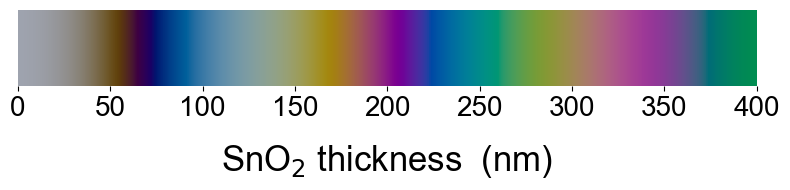

In [7]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'

rgb = RGB_res
rgbtuples = [tuple(i) for i in rgb]


df = pd.DataFrame([np.tile(np.arange(0, 401), 1),
                   np.repeat(np.arange(0, 1), 401),
                   rgbtuples],
                   index = ['Thick', 'Angle', 'rgb']).transpose()

df_pivot = df.pivot(index = 'Angle', columns = 'Thick', values = 'rgb')

fig, ax = plt.subplots(figsize = (8, 2))

df_pivot_asarray = np.array([[list(tup) for tup in row] for row in df_pivot.to_numpy()])

xlen = len(df_pivot.columns)
ylen = len(df_pivot.index)

ax.imshow(df_pivot_asarray.astype('uint8'), extent = [-0.5, xlen - 0.5, -0.5, ylen - 0.5],
         origin = 'lower', aspect = 'auto')

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.axis([0, 400, 0, 0.5])
ax.axes.yaxis.set_ticklabels([])

ax.yaxis.set_ticks([])

ax.set_xlabel('SnO$_2$ thickness  (nm)', fontsize = 25, labelpad = 15)

plt.tick_params(axis = 'both', direction = 'out', labelsize = 20)

plt.tight_layout()
plt.show()

# SiO₂

In [8]:
# Thickness
d_sno2 = 0
d_sio2_sam = np.arange(0, 1001, 1)

# Angle
angle = 0

RGB_res = np.zeros((len(d_sio2_sam), 3))

for i in range(len(d_sio2_sam)):
    d_sio2 = d_sio2_sam[i]
    r = reflectance(wl, N_air, N_sno2, N_sio2, N_si, d_sno2, d_sio2, angle)
    RGB_res[i] = reflectance2RGB(r, CMFs_X_i, CMFs_Y_i, CMFs_Z_i, D65)

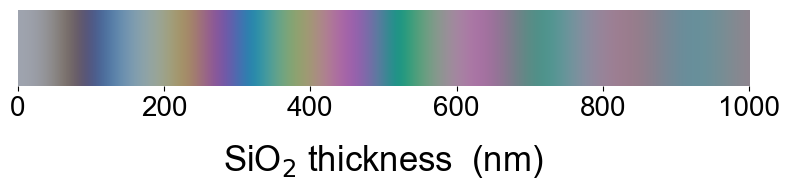

In [9]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'

rgb = RGB_res
rgbtuples = [tuple(i) for i in rgb]


df = pd.DataFrame([np.tile(np.arange(0, 1001), 1),
                   np.repeat(np.arange(0, 1), 1001),
                   rgbtuples],
                   index = ['Thick', 'Angle', 'rgb']).transpose()

df_pivot = df.pivot(index = 'Angle', columns = 'Thick', values = 'rgb')

fig, ax = plt.subplots(figsize = (8, 2))

df_pivot_asarray = np.array([[list(tup) for tup in row] for row in df_pivot.to_numpy()])

xlen = len(df_pivot.columns)
ylen = len(df_pivot.index)

ax.imshow(df_pivot_asarray.astype('uint8'), extent = [-0.5, xlen - 0.5, -0.5, ylen - 0.5],
         origin = 'lower', aspect = 'auto')

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.axis([0, 1000, 0, 0.5])
ax.axes.yaxis.set_ticklabels([])

ax.yaxis.set_ticks([])

ax.set_xlabel('SiO$_2$ thickness  (nm)', fontsize = 25, labelpad = 15)
# ax.set_ylabel('Angle (°)', fontsize = 25, labelpad = 15)

plt.tick_params(axis = 'both', direction = 'out', labelsize = 20)

plt.tight_layout()
plt.show()

# ZnO

In [10]:
# Standard wavelength
wl = np.arange(380, 750.1, 1)

def load_refractive_index(filename):
     data = pd.read_csv(filename)
     return data.iloc[:, 0].values, data.iloc[:, 1].values

def load_complex_index(filename):
     data = pd.read_csv(filename)
     return data.iloc[:, 0].values, data.iloc[:, 1].values, data.iloc[:, 2].values

# Air n, k
N_air = complex(1.0003, -0)
# imagenary unit
j = complex(0, 1)

# ZnO
wl_zno_n, n_zno = load_refractive_index('ZnO n Aguilar.csv')
wl_zno_k, k_zno = load_refractive_index('ZnO k Aguilar.csv')
n_zno_interp = interp1d(wl_zno_n, n_zno)(wl)
k_zno_interp = interp1d(wl_zno_k, k_zno)(wl)
N_zno = n_zno_interp - 1j * k_zno_interp
 
# SiO2
wl_sio2_n, n_sio2 = load_refractive_index('SiO2 n.csv')
n_sio2_interp = interp1d(wl_sio2_n, n_sio2)(wl)
N_sio2 = n_sio2_interp - 1j * 0  # No absorption
 
# Si
wl_si, n_si, k_si = load_complex_index('Si n k.csv')
n_si_interp = interp1d(wl_si, n_si)(wl)
k_si_interp = interp1d(wl_si, k_si)(wl)
N_si = n_si_interp - 1j * k_si_interp

# http://www.mtheiss.com/docs/code/?bk_d65_spectrum.htm
D65_spec = pd.read_csv("D65_step_1.csv")
D65 = D65_spec.iloc[0:371, 1].values
# http://cvrl.ucl.ac.uk/
# CMFs -> CIE 1931 2-deg, XYZ CMFs
cie_data = pd.read_csv('CIE_cc_1931_2deg_cvrl.csv')
cie_wl = cie_data.iloc[:, 0]
CMFs_X_b = cie_data.iloc[:, 1]; CMFs_Y_b = cie_data.iloc[:, 2]; CMFs_Z_b = cie_data.iloc[:, 3]

In [11]:
CMFs_X_i = interp1d(cie_wl, CMFs_X_b, kind = 'cubic')(wl)
CMFs_Y_i = interp1d(cie_wl, CMFs_Y_b, kind = 'cubic')(wl)
CMFs_Z_i = interp1d(cie_wl, CMFs_Z_b, kind = 'cubic')(wl)

In [12]:
# Eq. (4)
def reflection_p(N_j, N_k, ang_j, ang_k):
    r = (N_k * np.cos(ang_j) - N_j * np.cos(ang_k)) / (N_k * np.cos(ang_j) + N_j * np.cos(ang_k))
    return r
# Eq. (8)
def reflection_s(N_j, N_k, ang_j, ang_k):
    r = (N_j * np.cos(ang_j) - N_k * np.cos(ang_k)) / (N_j * np.cos(ang_j) + N_k * np.cos(ang_k))
    return r

def reflectance(wl, N_0, N_1, N_2, N_3, d_1, d_2, angle):
    # Snell's Law
    ang_0 = angle * np.pi / 180
    ang_1 = np.arcsin(N_0/N_1 * np.sin(ang_0))
    ang_2 = np.arcsin(N_0/N_2 * np.sin(ang_0))
    ang_3 = np.arcsin(N_0/N_3 * np.sin(ang_0))
    # Eq. (20)
    alpha_1 = 4 * np.pi * d_1 / wl * N_1 * np.cos(ang_1)
    alpha_2 = 4 * np.pi * d_2 / wl * N_2 * np.cos(ang_2)
    # Reflection coefficient of p-polarized wave at each interface
    r_01_p = reflection_p(N_0, N_1, ang_0, ang_1)
    r_12_p = reflection_p(N_1, N_2, ang_1, ang_2)
    r_23_p = reflection_p(N_2, N_3, ang_2, ang_3)
    # Eq. (27)
    r_0123_p = (r_01_p + r_12_p * np.exp(-j*alpha_1) 
                + (r_01_p*r_12_p + np.exp(-j*alpha_1))
                * r_23_p * np.exp(-j*alpha_2)) / (1 + r_01_p*r_12_p*np.exp(-j*alpha_1)
                                                   + (r_12_p + r_01_p*np.exp(-j*alpha_1))
                                                   * r_23_p*np.exp(-j*alpha_2))
    # Reflection coefficient of s-polarized wave at each interface
    r_01_s = reflection_s(N_0, N_1, ang_0, ang_1)
    r_12_s = reflection_s(N_1, N_2, ang_1, ang_2)
    r_23_s = reflection_s(N_2, N_3, ang_2, ang_3)
    # Eq. (27)
    r_0123_s = (r_01_s + r_12_s * np.exp(-j*alpha_1) 
                + (r_01_s*r_12_s + np.exp(-j*alpha_1))
                * r_23_s * np.exp(-j*alpha_2)) / (1 + r_01_s*r_12_s*np.exp(-j*alpha_1)
                                                   + (r_12_s + r_01_s*np.exp(-j*alpha_1))
                                                   * r_23_s*np.exp(-j*alpha_2))
    # Eq. (10)
    R_p = np.abs(r_0123_p)**2
    R_s = np.abs(r_0123_s)**2
    # Eq. (12)
    R_n = (R_p+R_s)/2
    return R_n

In [13]:
def reflectance2RGB(R_n, CMFs_X, CMFs_Y, CMFs_Z, D65):
    # Reflectance to CIE XYZ
    # http://www.brucelindbloom.com/index.html?Eqn_XYZ_to_RGB.html
    # Eq. (28)
    N = sum(CMFs_Y * D65)
    # Eq. (29)
    X = sum(CMFs_X * D65 * R_n) / N
    # Eq. (30)
    Y = sum(CMFs_Y * D65 * R_n) / N
    # Eq. (31)
    Z = sum(CMFs_Z * D65 * R_n) / N
    XYZ = np.array([X, Y, Z])

    # XYZ to RGB matrix (sRGB, D65)
    m = np.array([[3.24045, -1.53714, -0.49853],
                  [-0.96927, 1.87601, 0.04156],
                  [0.05564, -0.20403, 1.05723]])
    # Eq. (34)
    rgb_linear = np.dot(m, XYZ)
    # Eq. (35)
    def gamma_correct(c):
        return 12.92 * c if c <= 0.0031308 else 1.055 * (abs(c) ** (1 / 2.4)) - 0.055

    rgb = [gamma_correct(c) for c in rgb_linear]
    return np.round(np.clip(np.array(rgb) * 255, 0, 255)).astype(int)

In [14]:
# Thickness
d_arr = np.arange(0, 601, 1)

d_sio2 = 2

angle_arr = np.arange(1, 91, 1)
len_d = len(d_arr)
len_angle = len(angle_arr)
df_d = pd.DataFrame(d_arr)
a = np.full((len_d, 1), 0, dtype = np.float64)
df_a = pd.DataFrame(a)
data_in = pd.concat([df_a, df_d], axis = 1)

for i in range(len_angle):
    c = np.full((len_d, 1), angle_arr[i], dtype = np.float64)
    df_c = pd.DataFrame(c)
    data_c = pd.concat([df_c, df_d], axis = 1)
    data_in = pd.concat([data_in, data_c])
    
data_in.columns = ['0', '1']
RGB_res = np.zeros((len(data_in), 3))

for i in range(len(data_in)):
    angle = data_in.iloc[i, 0]
    d_zno = data_in.iloc[i, 1]

    r = reflectance(wl, N_air, N_zno, N_sio2, N_si, d_zno, d_sio2, angle)
    RGB_res[i] = reflectance2RGB(r, CMFs_X_i, CMFs_Y_i, CMFs_Z_i, D65)

[[158. 163. 174.]
 [158. 163. 174.]
 [158. 163. 174.]
 ...
 [255. 255. 255.]
 [255. 255. 255.]
 [255. 255. 255.]]


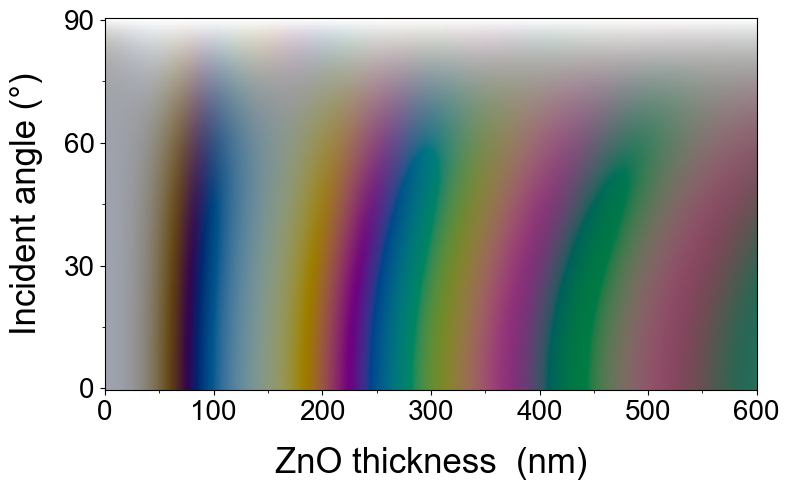

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'

rgb = RGB_res
rgbtuples = [tuple(i) for i in rgb]

df = pd.DataFrame([np.tile(np.arange(0, 601), 91),
                   np.repeat(np.arange(0, 91), 601),
                   rgbtuples],
                   index = ['Thick', 'Angle', 'rgb']).transpose()

df_pivot = df.pivot(index = 'Angle', columns = 'Thick', values = 'rgb')

fig, ax = plt.subplots(figsize = (8, 5))

df_pivot_asarray = np.array([[list(tup) for tup in row] for row in df_pivot.to_numpy()])

xlen = len(df_pivot.columns)
ylen = len(df_pivot.index)

ax.imshow(df_pivot_asarray.astype('uint8'), extent = [-0.5, xlen - 0.5, -0.5, ylen - 0.5],
         origin = 'lower', aspect = 'auto')

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(50))

ax.yaxis.set_major_locator(MultipleLocator(30))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(15))

ax.set_xlabel('ZnO thickness  (nm)', fontsize = 25, labelpad = 15)
ax.set_ylabel('Incident angle (°)', fontsize = 25, labelpad = 15)

plt.tick_params(axis = 'both', direction = 'out', labelsize = 20)

plt.tight_layout()
plt.show()